In [1]:
import secrets
import pandas as pd
import numpy as np # type: ignore
import seaborn as sns
import plotly.io as pio

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [2]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [3]:
import model.basic_model as basic_model
import model.agents as agents
from model.stochastic_processes import (
    create_stochastic_avail_price_process,
    plot_price,
)
from model.agents_class import Stake

In [4]:
# types
Run = int
Timestep = int

# Price Traj Generation

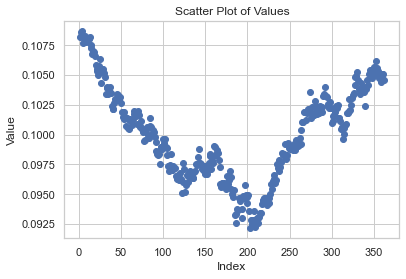

0.09212902731226363


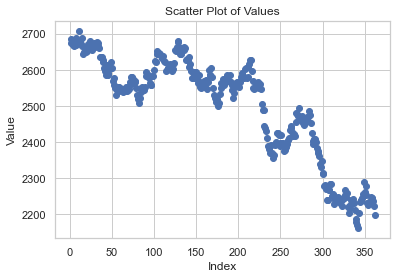

2160.900428270494


In [5]:
avl_price_samples = create_stochastic_avail_price_process(price_traj_type = 'concave',minimum_avl_price=0.05, target_avg=0.1, maximum_avl_price=1.0,)
plot_price(avl_price_samples) 
print(min(avl_price_samples))

eth_price_samples = create_stochastic_avail_price_process(price_traj_type = 'concave', minimum_avl_price=1500,target_avg=2500, maximum_avl_price=3000)
plot_price(eth_price_samples) 
print(min(eth_price_samples))

# Setup

In [6]:
constants = {
}

In [7]:
AVL_initial_price = avl_price_samples[0]
ETH_initial_price = eth_price_samples[0]
print(AVL_initial_price)

0.10816962298003223


In [8]:
ETH_upper_security_pct = [.65]
AVL_upper_security_pct = [.35]

# Simulation

In [9]:
init_agent_eth_alloc = [1, 0]
init_agent_avl_alloc = [1-i for i in init_agent_eth_alloc]
agents_composition = [ETH_upper_security_pct[0],AVL_upper_security_pct[0]] # sum = 1

In [10]:
init_AVL_price = AVL_initial_price
init_fdv = 10000000000 * init_AVL_price
init_inflation_rate = 4
init_rewards_allocation = 20
init_target_avg_yield = 5
init_total_inflation_rewards = init_fdv * init_inflation_rate /100
init_total_annual_rewards_fusion = init_total_inflation_rewards * init_rewards_allocation / 100


init_target_total_security = init_total_annual_rewards_fusion * 100 / init_target_avg_yield

print(init_target_total_security)

173071396.76805156


In [11]:
init_AVL_security_pct = [ i*j for i,j in zip(init_agent_avl_alloc, agents_composition)]
init_ETH_security_pct = [ i*j for i,j in zip(init_agent_eth_alloc, agents_composition)]

print(init_AVL_security_pct, init_ETH_security_pct)

init_total_AVL_security_pct = sum(init_AVL_security_pct)
init_total_ETH_security_pct = sum(init_ETH_security_pct)

print([i/init_total_AVL_security_pct for i in init_AVL_security_pct])
print([i/init_total_ETH_security_pct for i in init_ETH_security_pct])


agents_avl_balance = [init_target_total_security * pct / AVL_initial_price for pct in init_AVL_security_pct]
agents_eth_balance = [init_target_total_security * pct / ETH_initial_price for pct in init_ETH_security_pct]

print(agents_avl_balance)
print(agents_eth_balance)

[0.0, 0.35] [0.65, 0.0]
[0.0, 1.0]
[1.0, 0.0]
[np.float64(0.0), np.float64(560000000.0)]
[np.float64(42040.3182471141), np.float64(0.0)]


In [12]:
df = pd.DataFrame({
    'Agent ETH Allocation %': init_agent_eth_alloc,
    'Agent AVL Allocation %': init_agent_avl_alloc
})
df['Agent ETH Allocation %'] = df['Agent ETH Allocation %'].apply(lambda x: f"{x:.2%}")
df['Agent AVL Allocation %'] = df['Agent AVL Allocation %'].apply(lambda x: f"{x:.2%}")
print(df)


avl_normalized = [i / sum(init_AVL_security_pct) for i in init_AVL_security_pct]
eth_normalized = [i / sum(init_ETH_security_pct) for i in init_ETH_security_pct]

df = pd.DataFrame({
    'AVL Security %': avl_normalized,
    'ETH Security %': eth_normalized
})
df['AVL Security %'] = df['AVL Security %'].apply(lambda x: f"{x:.2%}")
df['ETH Security %'] = df['ETH Security %'].apply(lambda x: f"{x:.2%}")
print(df)


df = pd.DataFrame({
    'User Total Proportion': agents_composition
})
df['User Total Proportion'] = df['User Total Proportion'].apply(lambda x: f"{x:.2%}")
print(df)


df = pd.DataFrame({
    'Total Security %': [init_total_AVL_security_pct*100, init_total_ETH_security_pct*100]
}, index=['AVL', 'ETH'])
df['Total Security %'] = df['Total Security %'].apply(lambda x: f"{x:.0f}%")
print(df)

  Agent ETH Allocation % Agent AVL Allocation %
0                100.00%                  0.00%
1                  0.00%                100.00%
  AVL Security % ETH Security %
0          0.00%        100.00%
1        100.00%          0.00%
  User Total Proportion
0                65.00%
1                35.00%
    Total Security %
AVL              35%
ETH              65%


In [13]:
@dataclass
class FusionParams:
    # TODO: Set a AVL amount budget cap
    AVL_upper_budget_cap = 1.12e8
    ETH_upper_budget_cap = 2.08e8


    avl_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: avl_price_samples[timestep]]
    )
    eth_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: eth_price_samples[timestep]]
    )

    # inlation % on AVL
    inflation_rate: List[float] = default([init_inflation_rate])

    # % of Rewards Allocated to Fusion
    rewards_allocation: List[float] = default([init_rewards_allocation])


    # Reward Allocation to Pools
    ETH_reward_pct: List[float] = default([20])
    AVL_reward_pct: List[float] = default([80])


    # % of Fusion Security Standard met by ETH Stake
    # TODO: implementation
    ETH_upper_security_pct: List[float] = field(default_factory=lambda: ETH_upper_security_pct)
    AVL_upper_security_pct: List[float] = field(default_factory=lambda: AVL_upper_security_pct)



    # Agents
    ETH_agent_allocation: List[List[float]] = default([
        init_agent_eth_alloc
    ])
    AVL_agent_allocation: List[List[float]] = default([
        init_agent_avl_alloc
    ])
    # Agents_composition: List[List[float]] = default([
    #     agents_composition
    # ])

    # agents_avl_balance: List[List[float]] = default([
    #     agents_avl_balance
    # ])

    # agents_eth_balance: List[List[float]] = default([
    #     agents_eth_balance
    # ])

parameters = FusionParams().__dict__

In [14]:
def update_initial_state(simulation, eth_security_pct, avl_security_pct, avl_price, eth_price):
    # Update the security percentage for ETH and AVL
    agents_composition = [eth_security_pct[0], avl_security_pct[0]]
    init_agent_eth_alloc = [1, 0]
    init_agent_avl_alloc = [1 - i for i in init_agent_eth_alloc]
    
    # Initial conditions
    init_fdv = 10000000000 * avl_price
    init_inflation_rate = 4
    init_rewards_allocation = 20
    init_target_avg_yield = 5
    init_total_inflation_rewards = init_fdv * init_inflation_rate / 100
    init_total_annual_rewards_fusion = init_total_inflation_rewards * init_rewards_allocation / 100
    init_target_total_security = init_total_annual_rewards_fusion * 100 / init_target_avg_yield
    
    # Calculate security percentages
    init_AVL_security_pct = [i * j for i, j in zip(init_agent_avl_alloc, agents_composition)]
    init_ETH_security_pct = [i * j for i, j in zip(init_agent_eth_alloc, agents_composition)]
    
    # Compute balances based on updated percentages
    agents_avl_balance = [init_target_total_security * pct / avl_price for pct in init_AVL_security_pct]
    agents_eth_balance = [init_target_total_security * pct / eth_price for pct in init_ETH_security_pct]
    
    # Update the initial state in the simulation model
    simulation.model.initial_state.update({
        "timestep": 0,
        "avl_price": avl_price,
        "eth_price": eth_price, 
        "AVL_security_pct": sum(init_AVL_security_pct) * 100,
        "ETH_security_pct": sum(init_ETH_security_pct) * 100,
        "total_security": init_target_total_security,
        "total_fdv": init_fdv,
        "total_annual_rewards": init_total_inflation_rewards,
        "total_annual_rewards_fusion": init_total_annual_rewards_fusion,
        "avg_yield": init_target_avg_yield,
        "ETH_stake": Stake(eth_price, agents_eth_balance, 0, 0),
        "AVL_stake": Stake(avl_price, agents_avl_balance, 0, 0),
        "yield_pcts": [0, 0],
        "avg_yield": 0.0,
    })
    
    # Return updated security percentages and balances for confirmation
    return init_AVL_security_pct, init_ETH_security_pct, agents_avl_balance, agents_eth_balance


In [15]:
psub = [
    {
        "policies": {
             },
        "variables": {
            "timestep": basic_model.update_timestep,
            "avl_price": basic_model.update_avl_price,
            "eth_price": basic_model.update_eth_price,
        }
    },
    {
        "policies": {
            "action":basic_model.calc_rewards
             },
        "variables": {
            "total_annual_rewards": basic_model.update_total_annual_rewards,
            "total_annual_rewards_fusion": basic_model.update_total_annual_rewards_fusion,
            "total_fdv": basic_model.update_total_fdv,
        }
    }, 
    {
        "policies": {
            "action": basic_model.calc_security_shares
            },
            "variables": {
                "AVL_security_pct": basic_model.update_AVL_pct,
                "ETH_security_pct": basic_model.update_ETH_pct,
                "total_security": basic_model.update_total_security,
                "ETH_stake": basic_model.update_ETH_stake,
                "AVL_stake": basic_model.update_AVL_stake,
            }
    },
    {
        "policies": {
            "action": basic_model.calc_agents_balances
            },
            "variables": {
                "ETH_stake": basic_model.update_ETH_stake,
                "AVL_stake": basic_model.update_AVL_stake,
            }
    },
    {
        "policies": {
            "action": agents.calc_rewards_allocation
            },
            "variables": {
                "AVL_stake": agents.update_AVL_stake,
                "ETH_stake": agents.update_ETH_stake,
            }
    },
    {
        "policies": {
            "action": agents.calc_yields
            },
            "variables": {
                "yield_pcts": agents.update_yields,
                "avg_yield": agents.update_avg_yield,
            }
    },
]

initial_conditions = {
    "timestep": 0,
    "avl_price": AVL_initial_price,
    "eth_price": ETH_initial_price, 
    "AVL_security_pct": sum(init_AVL_security_pct) * 100,
    "ETH_security_pct": sum(init_ETH_security_pct) * 100,
    "total_security": init_target_total_security,
    # "target_total_security": init_target_total_security,
    "total_fdv": init_fdv,
    "total_annual_rewards": init_total_inflation_rewards,
    "total_annual_rewards_fusion": init_total_annual_rewards_fusion,
    "avg_yield": 5.0,
    "ETH_stake": Stake(ETH_initial_price, agents_eth_balance,0,0),
    "AVL_stake": Stake(AVL_initial_price, agents_avl_balance,0,0),
    "yield_pcts": [0,0],
    "avg_yield": 0.0,
}


params = parameters



In [16]:
model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=params
)


In [17]:
simulation = []
df = []
for avl_rewards_alloc_pct in range(10, 101, 10):
    for i in range(9):
        simulation.append(Simulation(model=model, timesteps=300, runs=1))
        ETH_upper_security_pct = 0.1*i+0.1 # starting from 10% to 90%
        simulation[-1].model.params.update({
            "ETH_upper_security_pct": [ETH_upper_security_pct],
            "AVL_upper_security_pct": [1-ETH_upper_security_pct],
            "AVL_reward_pct": [avl_rewards_alloc_pct],
            "ETH_reward_pct": [100 - avl_rewards_alloc_pct],

        })
        update_initial_state(simulation[-1], 
                        [ETH_upper_security_pct], 
                        [1-ETH_upper_security_pct], 
                        AVL_initial_price, ETH_initial_price)
        print(simulation[-1].model.params)
        experiment = Experiment([simulation[-1]])
        experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
        results  = experiment.run()
        df.append(pd.DataFrame(results))






{'avl_price_process': [<function FusionParams.<lambda> at 0x14266e700>], 'eth_price_process': [<function FusionParams.<lambda> at 0x1426540d0>], 'inflation_rate': [4], 'rewards_allocation': [20], 'ETH_reward_pct': [90], 'AVL_reward_pct': [10], 'ETH_upper_security_pct': [0.1], 'AVL_upper_security_pct': [0.9], 'ETH_agent_allocation': [[1, 0]], 'AVL_agent_allocation': [[0, 1]]}
{'avl_price_process': [<function FusionParams.<lambda> at 0x14266e700>], 'eth_price_process': [<function FusionParams.<lambda> at 0x1426540d0>], 'inflation_rate': [4], 'rewards_allocation': [20], 'ETH_reward_pct': [90], 'AVL_reward_pct': [10], 'ETH_upper_security_pct': [0.2], 'AVL_upper_security_pct': [0.8], 'ETH_agent_allocation': [[1, 0]], 'AVL_agent_allocation': [[0, 1]]}
{'avl_price_process': [<function FusionParams.<lambda> at 0x14266e700>], 'eth_price_process': [<function FusionParams.<lambda> at 0x1426540d0>], 'inflation_rate': [4], 'rewards_allocation': [20], 'ETH_reward_pct': [90], 'AVL_reward_pct': [10], 

In [18]:
simulation[0].model.params

{'avl_price_process': [<function __main__.FusionParams.<lambda>(run, timestep)>],
 'eth_price_process': [<function __main__.FusionParams.<lambda>(run, timestep)>],
 'inflation_rate': [4],
 'rewards_allocation': [20],
 'ETH_reward_pct': [0],
 'AVL_reward_pct': [100],
 'ETH_upper_security_pct': [0.9],
 'AVL_upper_security_pct': [0.09999999999999998],
 'ETH_agent_allocation': [[1, 0]],
 'AVL_agent_allocation': [[0, 1]]}

In [19]:
from post_process_stats import aggregate_summary

In [20]:
summary_df = aggregate_summary(df,simulation)
print(summary_df)

    AVL_security_pct_mean  AVL_security_pct_std  total_security_mean  \
0               89.634564              0.462442         1.595288e+08   
1               79.357137              0.815990         1.601579e+08   
2               69.165016              1.063184         1.607870e+08   
3               59.055592              1.206417         1.614162e+08   
4               49.026343              1.247942         1.620453e+08   
..                    ...                   ...                  ...   
85              49.026343              1.247942         1.620453e+08   
86              39.074829              1.189884         1.626744e+08   
87              29.198689              1.034240         1.633035e+08   
88              19.395637              0.782887         1.639326e+08   
89               9.663457              0.437589         1.645618e+08   

    total_security_std  avg_yield_mean  avg_yield_std  eth_yield_mean  \
0         5.714932e+06        4.962979       0.288153       43

In [21]:
summary_df.to_csv('aggregated_summary_statistics.csv', index=False)

In [29]:
df[10]

timestep  avl_price    eth_price  AVL_security_pct  ETH_security_pct  \
0            0   0.108170  2675.917134         80.000000         20.000000   
1            1   0.108170  2675.917134         80.000000         20.000000   
2            1   0.108170  2675.917134         80.000000         20.000000   
3            1   0.108170  2675.917134         80.000000         20.000000   
4            1   0.108170  2675.917134         80.000000         20.000000   
...        ...        ...          ...               ...               ...   
1796       300   0.100973  2314.840262         81.170542         18.829458   
1797       300   0.100973  2314.840262         81.189878         18.810122   
1798       300   0.100973  2314.840262         81.189878         18.810122   
1799       300   0.100973  2314.840262         81.189878         18.810122   
1800       300   0.100973  2314.840262         81.189878         18.810122   

      total_security     total_fdv  total_annual_rewards  \
0       1.730714e+08  1.081696e+09          4.326785e+07   
1       1.730714e+08  1.081696e+09          4.326785e+07   
2       1.730714e+08  1.081696e+09          4.326785e+07   
3       1.730714e+08  1.081696e+09          4.326785e+07   
4       1.730714e+08  1.081696e+09          4.326785e+07   
...              ...           ...                   ...   
1796    1.612289e+08  1.009727e+09          4.038908e+07   
1797    1.591886e+08  1.009727e+09          4.038908e+07   
1798    1.591886e+08  1.009727e+09          4.038908e+07   
1799    1.591886e+08  1.009727e+09          4.038908e+07   
1800    1.591886e+08  1.009727e+09          4.038908e+07   

      total_annual_rewards_fusion  avg_yield  \
0                    8.653570e+06   0.000000   
1                    8.653570e+06   0.000000   
2                    8.653570e+06   0.000000   
3                    8.653570e+06   0.000000   
4                    8.653570e+06   0.000000   
...                           ...        ...   
1796                 8.077816e+06   5.073159   
1797                 8.077816e+06   5.073159   
1798                 8.077816e+06   5.073159   
1799                 8.077816e+06   5.073159   
1800                 8.077816e+06   5.074367   

                                              ETH_stake  \
0     Stake(initial_price=np.float64(2675.9171335948...   
1     Stake(initial_price=np.float64(2675.9171335948...   
2     Stake(initial_price=np.float64(2675.9171335948...   
3     Stake(initial_price=np.float64(2675.9171335948...   
4     Stake(initial_price=np.float64(2675.9171335948...   
...                                                 ...   
1796  Stake(initial_price=np.float64(2346.9194075855...   
1797  Stake(initial_price=np.float64(2314.8402621304...   
1798  Stake(initial_price=np.float64(2314.8402621304...   
1799  Stake(initial_price=np.float64(2314.8402621304...   
1800  Stake(initial_price=np.float64(2314.8402621304...   

                                              AVL_stake  \
0     Stake(initial_price=np.float64(0.1081696229800...   
1     Stake(initial_price=np.float64(0.1081696229800...   
2     Stake(initial_price=np.float64(0.1081696229800...   
3     Stake(initial_price=np.float64(0.1081696229800...   
4     Stake(initial_price=np.float64(0.1081696229800...   
...                                                 ...   
1796  Stake(initial_price=np.float64(0.1022425004996...   
1797  Stake(initial_price=np.float64(0.1009726970606...   
1798  Stake(initial_price=np.float64(0.1009726970606...   
1799  Stake(initial_price=np.float64(0.1009726970606...   
1800  Stake(initial_price=np.float64(0.1009726970606...   

                                   yield_pcts  simulation  subset  run  \
0                                      [0, 0]           0       0    1   
1                                      [0, 0]           0       0    1   
2                                      [0, 0]           0       0    1   
3                                      [0, 0]           0

In [23]:
df[1]

timestep  avl_price    eth_price  AVL_security_pct  ETH_security_pct  \
0            0   0.108170  2675.917134         80.000000         20.000000   
1            1   0.108170  2675.917134         80.000000         20.000000   
2            1   0.108170  2675.917134         80.000000         20.000000   
3            1   0.108170  2675.917134         80.000000         20.000000   
4            1   0.108170  2675.917134         80.000000         20.000000   
...        ...        ...          ...               ...               ...   
1796       300   0.100973  2314.840262         81.170542         18.829458   
1797       300   0.100973  2314.840262         81.189878         18.810122   
1798       300   0.100973  2314.840262         81.189878         18.810122   
1799       300   0.100973  2314.840262         81.189878         18.810122   
1800       300   0.100973  2314.840262         81.189878         18.810122   

      total_security     total_fdv  total_annual_rewards  \
0       1.730714e+08  1.081696e+09          4.326785e+07   
1       1.730714e+08  1.081696e+09          4.326785e+07   
2       1.730714e+08  1.081696e+09          4.326785e+07   
3       1.730714e+08  1.081696e+09          4.326785e+07   
4       1.730714e+08  1.081696e+09          4.326785e+07   
...              ...           ...                   ...   
1796    1.612289e+08  1.009727e+09          4.038908e+07   
1797    1.591886e+08  1.009727e+09          4.038908e+07   
1798    1.591886e+08  1.009727e+09          4.038908e+07   
1799    1.591886e+08  1.009727e+09          4.038908e+07   
1800    1.591886e+08  1.009727e+09          4.038908e+07   

      total_annual_rewards_fusion  avg_yield  \
0                    8.653570e+06   0.000000   
1                    8.653570e+06   0.000000   
2                    8.653570e+06   0.000000   
3                    8.653570e+06   0.000000   
4                    8.653570e+06   0.000000   
...                           ...        ...   
1796                 8.077816e+06   5.073159   
1797                 8.077816e+06   5.073159   
1798                 8.077816e+06   5.073159   
1799                 8.077816e+06   5.073159   
1800                 8.077816e+06   5.074367   

                                              ETH_stake  \
0     Stake(initial_price=np.float64(2675.9171335948...   
1     Stake(initial_price=np.float64(2675.9171335948...   
2     Stake(initial_price=np.float64(2675.9171335948...   
3     Stake(initial_price=np.float64(2675.9171335948...   
4     Stake(initial_price=np.float64(2675.9171335948...   
...                                                 ...   
1796  Stake(initial_price=np.float64(2346.9194075855...   
1797  Stake(initial_price=np.float64(2314.8402621304...   
1798  Stake(initial_price=np.float64(2314.8402621304...   
1799  Stake(initial_price=np.float64(2314.8402621304...   
1800  Stake(initial_price=np.float64(2314.8402621304...   

                                              AVL_stake  \
0     Stake(initial_price=np.float64(0.1081696229800...   
1     Stake(initial_price=np.float64(0.1081696229800...   
2     Stake(initial_price=np.float64(0.1081696229800...   
3     Stake(initial_price=np.float64(0.1081696229800...   
4     Stake(initial_price=np.float64(0.1081696229800...   
...                                                 ...   
1796  Stake(initial_price=np.float64(0.1022425004996...   
1797  Stake(initial_price=np.float64(0.1009726970606...   
1798  Stake(initial_price=np.float64(0.1009726970606...   
1799  Stake(initial_price=np.float64(0.1009726970606...   
1800  Stake(initial_price=np.float64(0.1009726970606...   

                                   yield_pcts  simulation  subset  run  \
0                                      [0, 0]           0       0    1   
1                                      [0, 0]           0       0    1   
2                                      [0, 0]           0       0    1   
3                                      [0, 0]           0

In [24]:
df[1].columns

Index(['timestep', 'avl_price', 'eth_price', 'AVL_security_pct',
       'ETH_security_pct', 'total_security', 'total_fdv',
       'total_annual_rewards', 'total_annual_rewards_fusion', 'avg_yield',
       'ETH_stake', 'AVL_stake', 'yield_pcts', 'simulation', 'subset', 'run',
       'substep', 'eth_yield', 'avl_yield'],
      dtype='object')

In [25]:
visualizations.plot_token_price_per_subset(
    df[0],
    scenario_names={
        0: "downside",
    }
)

In [26]:
for i in range(9):
    fig= visualizations.plot_security_pct(
        df[i]
    )
    pio.show(fig)


In [27]:
for i in range(9):
    fig = visualizations.plot_avg_overall_yield(
        df[i]
    )
    pio.show(fig)


In [28]:
for i in range(9):
    fig = visualizations.plot_yield_pct(
        df[i], init_agent_eth_alloc
    )
    pio.show(fig)